# Chargement des bibliothèques et des données

In [1]:
# Import useful libraries
import pandas as pd
import json
import numpy as np

# Import Google Drive
from google.colab import drive
drive.mount('/content/drive')

# returns JSON object as a dictionary
f = open('/content/drive/MyDrive/Iceberg/train.json',) # The train.json file needs to be in an "Iceberg" directory

# creating a dataframe
df_raw = pd.DataFrame(json.load(f))

# Train/test split
df_full = df_raw.sample(frac = 0.8, random_state = 42)
df_test = df_raw.drop(df_full.index)

# Changing inc_angle from object to float64
df_full.replace('na', np.NaN, inplace = True) # Replacing the 'na' text in inc_angle by NaN
df_full['inc_angle'].astype('float', copy = False) # Casting inc_angle to float works with the NaN
df_full[df_full.inc_angle.isna()] # 133 NaN

# Adding more features to the initial dataset
def add_features(data, label) :
  data['max_b'+str(label)] = [np.max(np.array(matx)) for matx in data['band_'+str(label)]]
  data['min_b'+str(label)] = [np.min(np.array(matx)) for matx in data['band_'+str(label)]]
  data['delta_b'+str(label)] = [(np.max(np.array(matx))-np.min(np.array(matx))) for matx in data['band_'+str(label)]]
  data['median_b'+str(label)] = [np.median(np.array(matx)) for matx in data['band_'+str(label)]]
  data['mean_b'+str(label)] = [np.mean(np.array(matx)) for matx in data['band_'+str(label)]]
  data['argmax_b'+str(label)] = [np.argmax(np.array(matx)) for matx in data['band_'+str(label)]]
  data['argmin_b'+str(label)] = [np.argmin(np.array(matx)) for matx in data['band_'+str(label)]]
  data['band_'+str(label)] = [np.array(matx) for matx in data['band_'+str(label)]]
  return data
  
df_full = add_features(df_full,1)
df_full = add_features(df_full,2)

df_full['delta_max'] = df_full[['delta_b1','delta_b2']].apply(np.max,axis=1)

# Creating the two weighted bands
df_full["band_2ab"] = (2*(np.array(df_full["band_1"])-np.array(df_full["min_b1"]))+(1*np.array(df_full["band_2"]-np.array(df_full["min_b2"]))))/(3) # WITHOUT DIVIDING BY RANGE HERE (not needed for naive)
df_full["band_a2b"] = (1*(np.array(df_full["band_1"])-np.array(df_full["min_b1"]))+(2*np.array(df_full["band_2"]-np.array(df_full["min_b2"]))))/(3)

# Creating the final dataframe
df = pd.DataFrame()
df['band_1'] = df_full["band_2ab"]
df['band_2'] = df_full["band_a2b"]
df['is_iceberg'] = df_full['is_iceberg']

Mounted at /content/drive


In [2]:
from sklearn.model_selection import train_test_split

# selecting the prediction target and the model features
y = df["is_iceberg"]
X = pd.DataFrame(df.band_1.to_list(), index=df.index, columns=[f"band_1_{i}" for i in range(75*75)]).join(pd.DataFrame(df.band_2.to_list(), index=df.index, columns=[f"band_2_{i}" for i in range(75*75)]))

# split data into training and validation data, for both features and target
# The split is based on a random number generator. 
# Supplying a numeric value to the random_state argument guarantees we get the same 
# split every time we run this script.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

# Classification

Plusieurs modèles sont essayés, et les choix d'hyperparamètres du plus performant sont affinés (des simulations avaient déjà été lancées pour tester des paramètres à côté).


In [4]:
from app import EvaluateAndReport

er = EvaluateAndReport(df_full, X_train, X_test, y_train, y_test)

--- Grid Search Report ---
Best parameters for DecisionTreeClassifier() :
 {'max_features': None, 'min_samples_leaf': 4} with f1 score 0.635
--- Cross Validation Report ---
Mean accuracy score 0.635 with std 0.057
Mean f1 score 0.599 with std 0.065
Mean precision score 0.624 with std 0.074
Mean recall score 0.58 with std 0.08
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.667
 f1 : 0.654
 precision : 0.664
 recall : 0.643
Confusion matrix for the test sample :


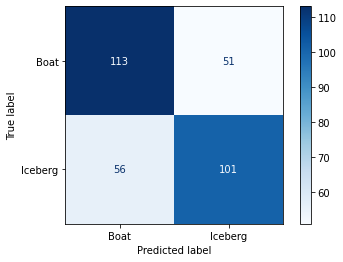

In [ ]:
from sklearn.tree import DecisionTreeClassifier

param_grid = [{
    'min_samples_leaf': [4],
    'max_features': [None]
}]
er.grid_cross_test_report(DecisionTreeClassifier(), param_grid)

--- Threshold Report ---
Optimal threshold for accuracy is 0.88 with:
 accuracy : 0.638
 f1 : 0.578
 precision : 0.642
 recall : 0.525
Optimal threshold for f1 is 0.0 with:
 accuracy : 0.471
 f1 : 0.64
 precision : 0.471
 recall : 1.0


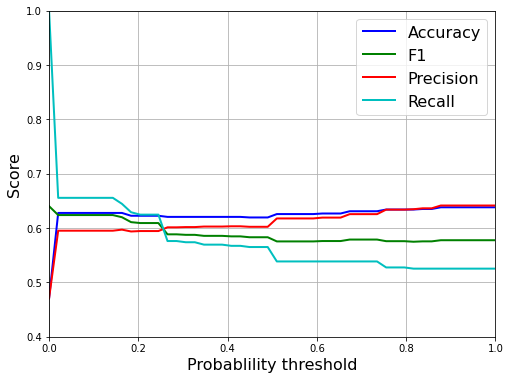

In [ ]:
er.full_cross_proba_report()

In [6]:
from sklearn.svm import SVC

--- Grid Search Report ---
Best parameters for SVC(probability=True) :
 {'C': 10.0} with f1 score 0.759
--- Cross Validation Report ---
Mean accuracy score 0.78 with std 0.045
Mean f1 score 0.766 with std 0.048
Mean precision score 0.768 with std 0.059
Mean recall score 0.768 with std 0.059
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.788
 f1 : 0.785
 precision : 0.78
 recall : 0.79
Confusion matrix for the test sample :


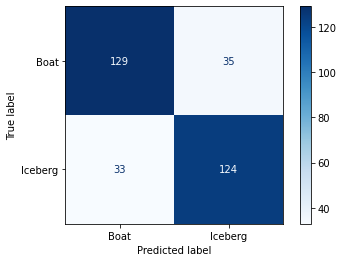

In [ ]:
param_grid = [{
    'C': np.logspace(-1, 1, 5)
}]
er.grid_cross_test_report(SVC(kernel='rbf', gamma='scale',probability=True), param_grid)

--- Threshold Report ---
Optimal threshold for accuracy is 1.0 with:
 accuracy : 0.529
 f1 : 0.0
 precision : 0.0
 recall : 0.0
Optimal threshold for f1 is 0.0 with:
 accuracy : 0.471
 f1 : 0.64
 precision : 0.471
 recall : 1.0


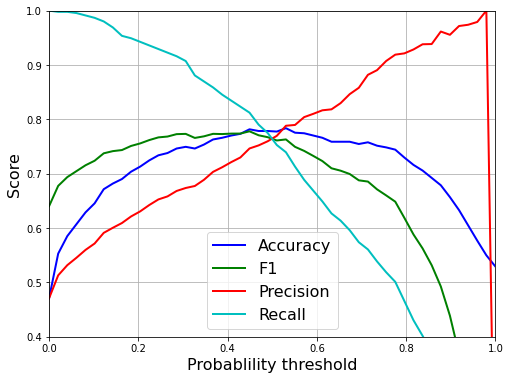

In [ ]:
er.full_cross_proba_report() # note: the function for optimal threshold doesn't work very well sometimes

In [ ]:
er.cross_proba_report(threshold=0.4)

--- Cross Validation with 0.4 Threshold Report ---
 accuracy : 0.769
 f1 : 0.774
 precision : 0.718
 recall : 0.841


--- Grid Search Report ---
Best parameters for SVC(probability=True) :
 {'C': 10.0} with f1 score 0.759
--- Cross Validation Report ---
Mean accuracy score 0.78 with std 0.045
Mean f1 score 0.766 with std 0.048
Mean precision score 0.768 with std 0.059
Mean recall score 0.768 with std 0.059
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.788
 f1 : 0.785
 precision : 0.78
 recall : 0.79
Confusion matrix for the test sample :


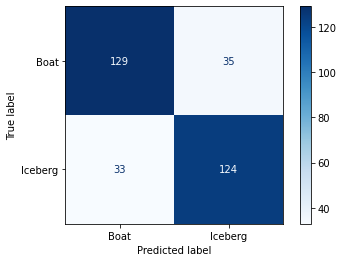

In [ ]:
param_grid = [{
    'C': np.logspace(0, 2, 5)
}]
er.grid_cross_test_report(SVC(kernel='rbf', gamma='scale',probability=True), param_grid)

--- Cross Validation Report ---
Mean accuracy score 0.78 with std 0.045
Mean f1 score 0.766 with std 0.048
Mean precision score 0.768 with std 0.059
Mean recall score 0.768 with std 0.059
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.788
 f1 : 0.785
 precision : 0.78
 recall : 0.79
Confusion matrix for the test sample :


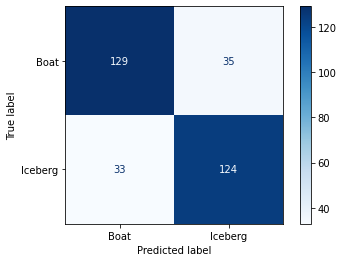

In [7]:
er.cross_test_report(SVC(C = 10, kernel='rbf', gamma='scale',probability=True))

--- Icebergs predicted as boats ---
Index : 1140


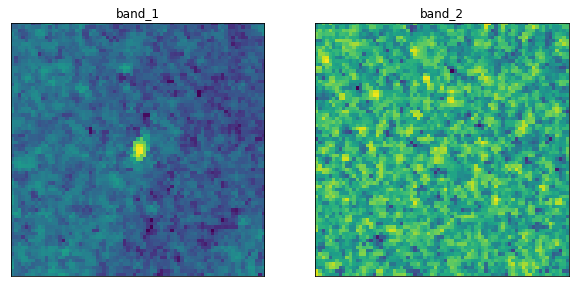

Index : 367


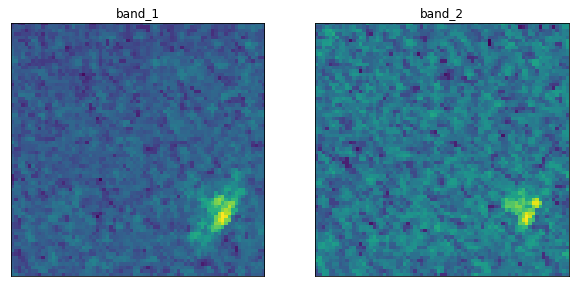

Index : 1078


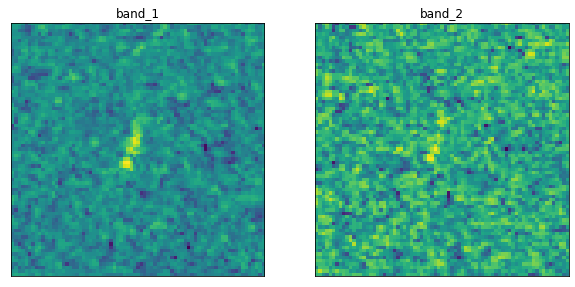

Index : 1022


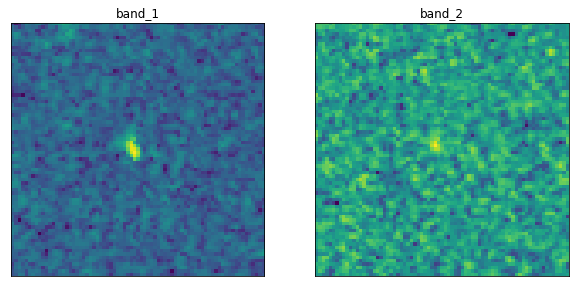

Index : 1235


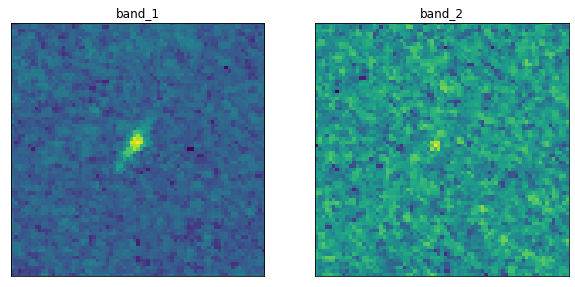

Index : 447


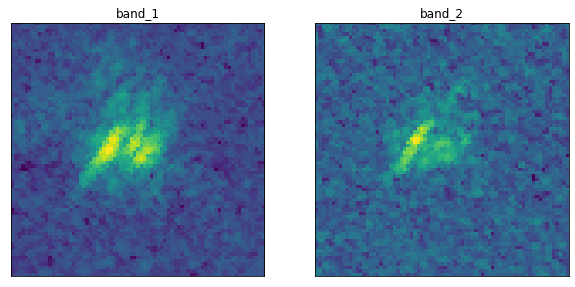

Index : 506


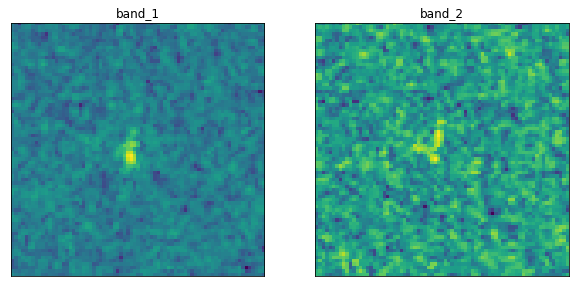

Index : 1062


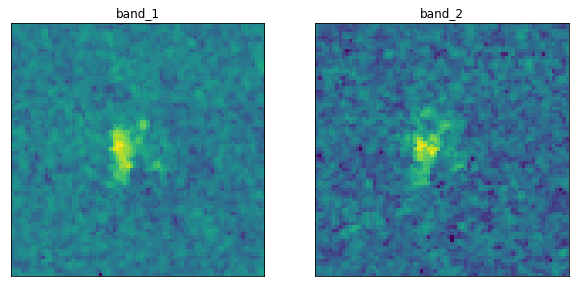

Index : 504


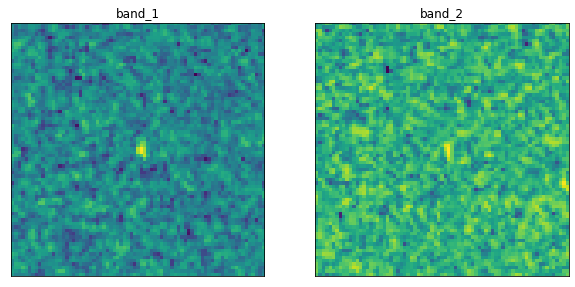

Index : 128


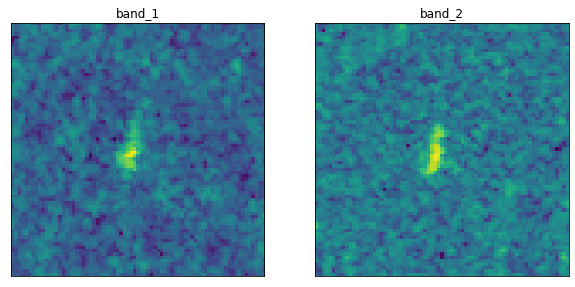

Index : 1170


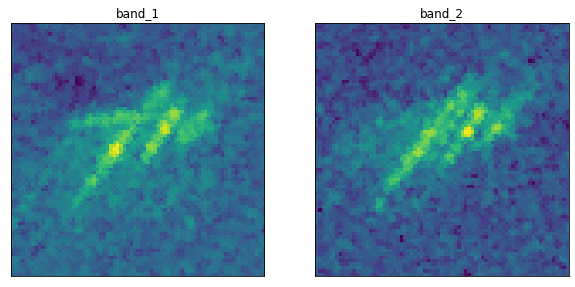

Index : 1169


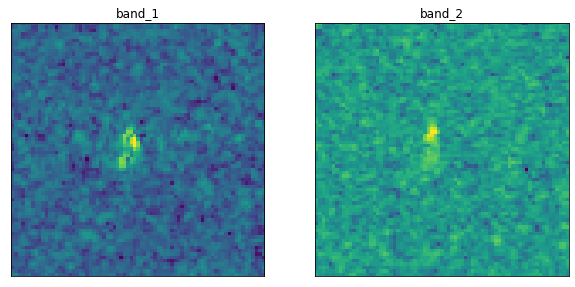

Index : 576


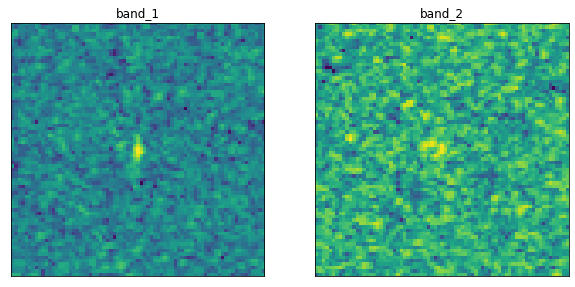

Index : 736


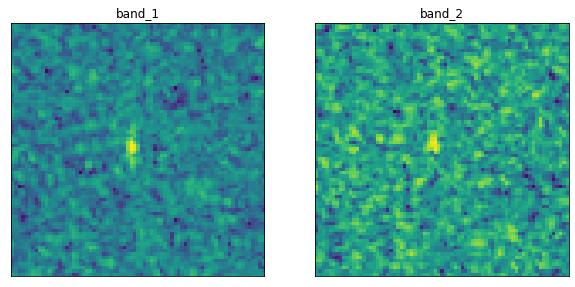

Index : 346


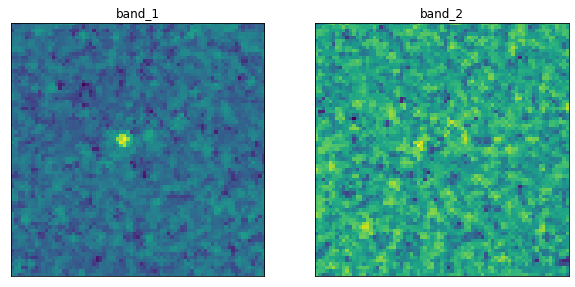

Index : 656


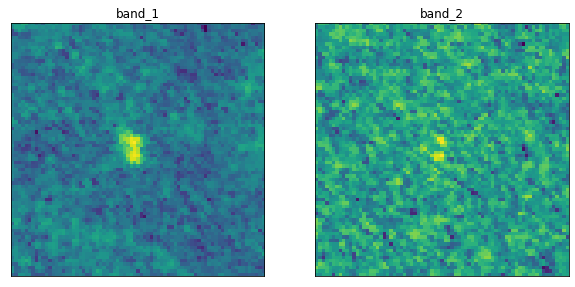

Index : 1106


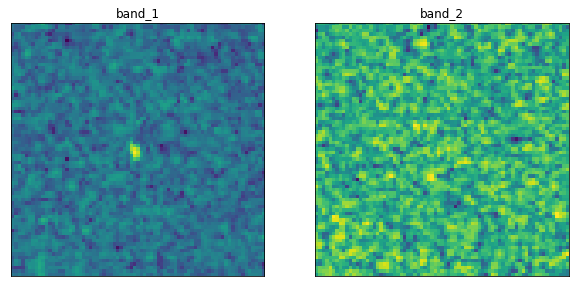

Index : 1498


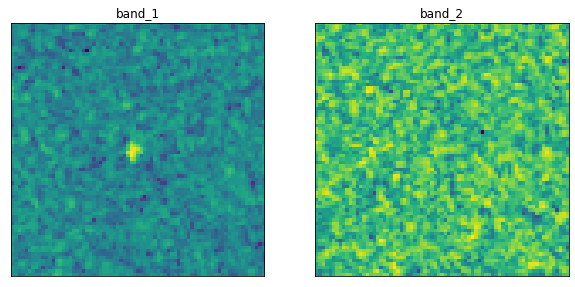

Index : 772


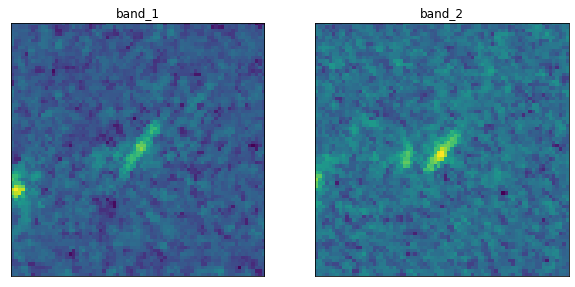

Index : 394


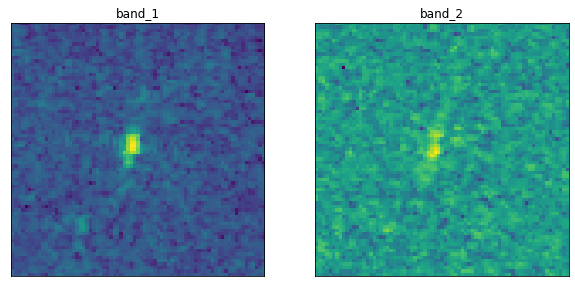

--- Boats predicted as Icebergs ---
Index : 693


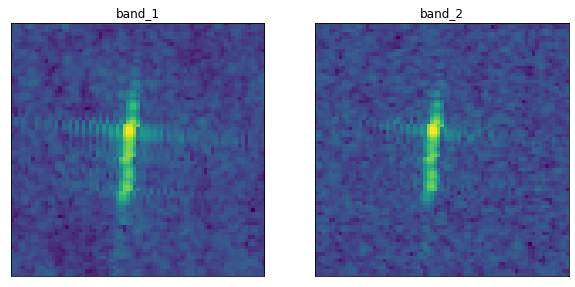

Index : 997


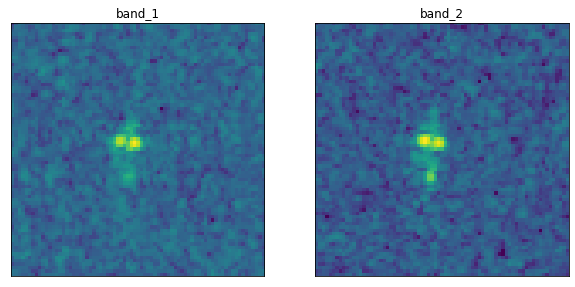

Index : 983


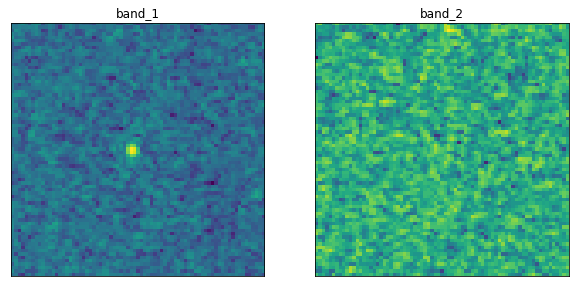

Index : 171


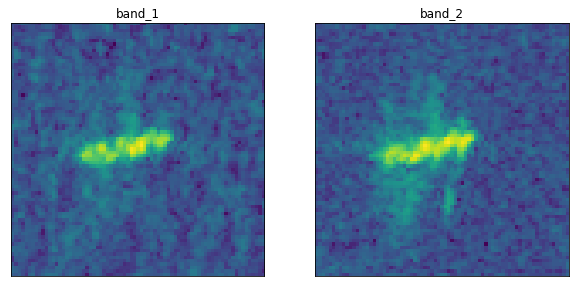

Index : 1208


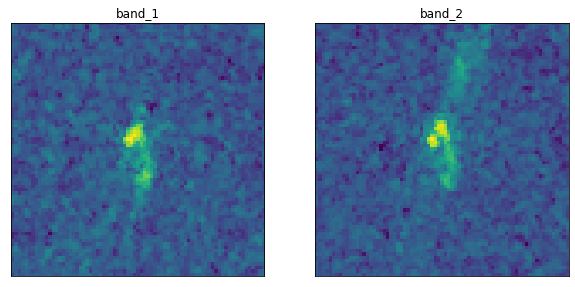

Index : 1035


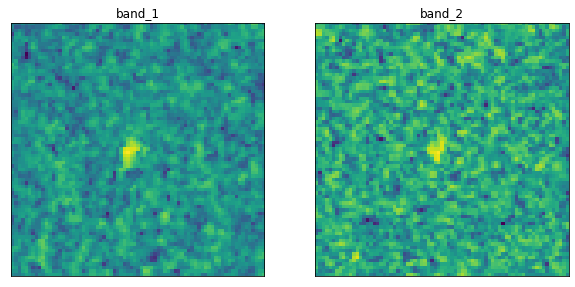

Index : 1229


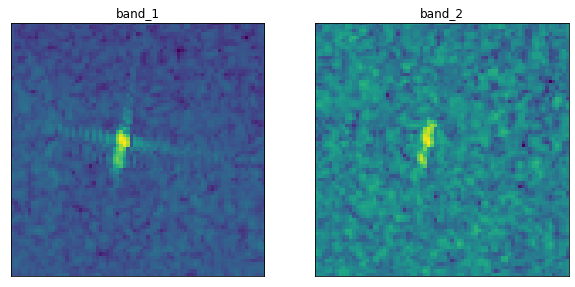

Index : 1603


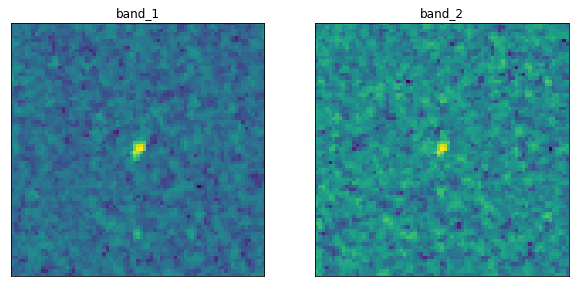

Index : 250


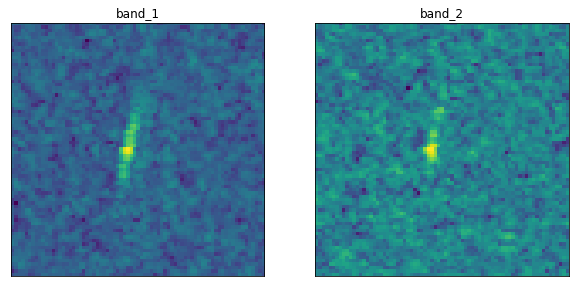

Index : 79


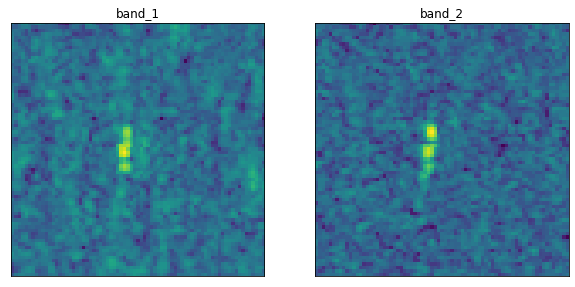

Index : 1494


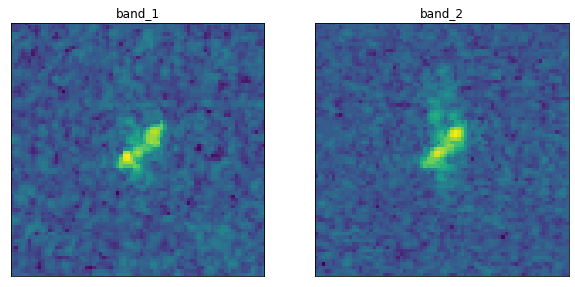

Index : 873


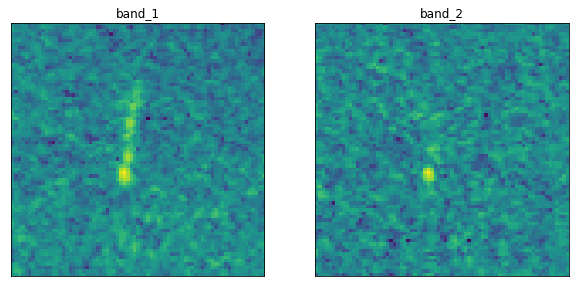

Index : 359


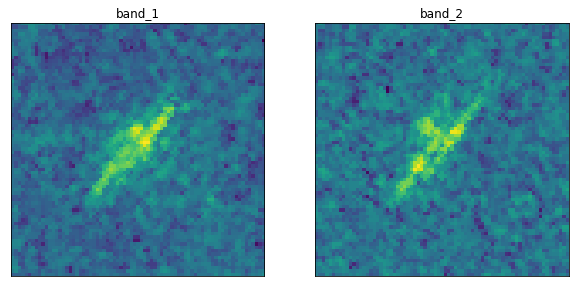

Index : 1175


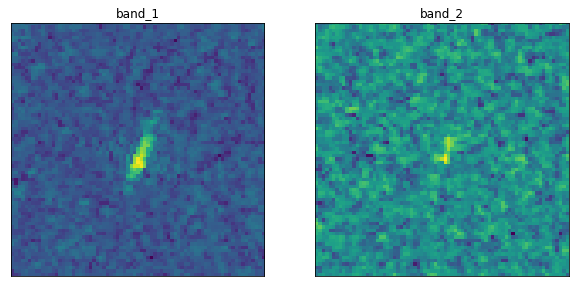

Index : 735


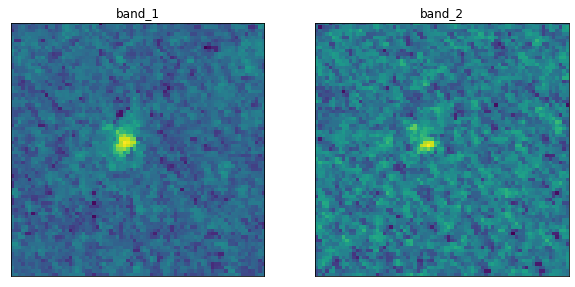

Index : 1412


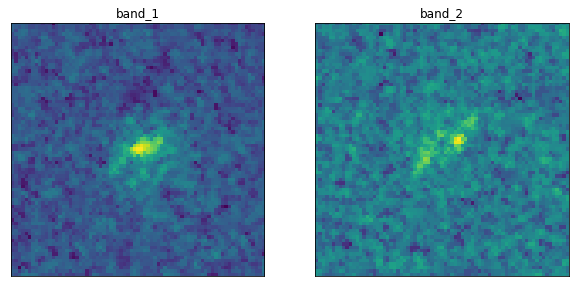

Index : 1476


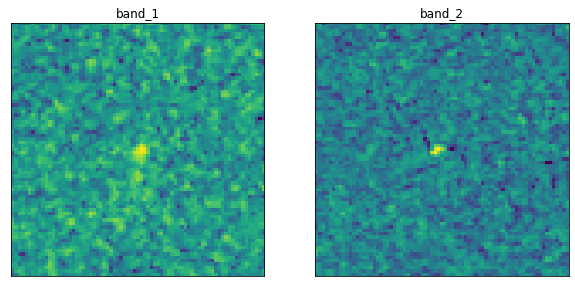

Index : 1338


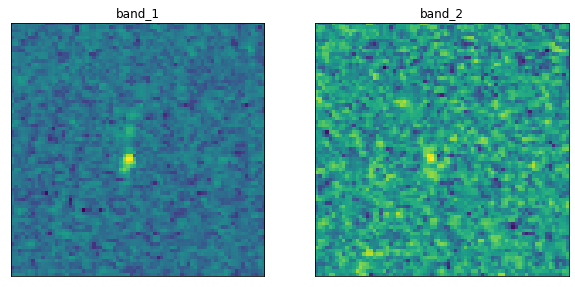

Index : 708


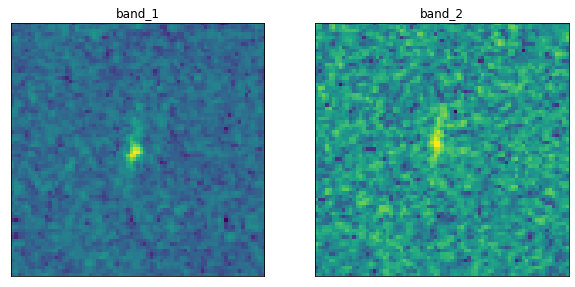

Index : 581


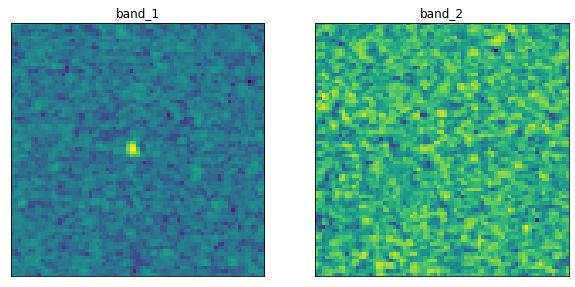

In [8]:
er.plot_mistakes(nb_samples = 20)